# AFM-FS

## Definition

### Import

In [1]:
# -*- coding: utf-8 -*-

# ---------------------------------------------------------------- # 
# ---------------------------- Import ---------------------------- # 
# ---------------------------------------------------------------- # 

import os
import time
import datetime

import numpy as np
import scipy.io as sio
import imageio

import matplotlib as mpl
import matplotlib.pyplot as plt

import cv2 as cv
from PIL import Image

from tqdm import tqdm

import tensorflow as tf        # tensorflow 1.X
import tensorflow.contrib.slim as slim

from fastprogress import master_bar, progress_bar

from IPython.display import clear_output

clear_output()

### System Configuration

In [2]:
# ---------------------------------------------------------------- # 
# --------------------- System Configuration --------------------- # 
# ---------------------------------------------------------------- # 

### Config matplotlib
mpl.rcParams['font.family']      = 'YaHei Consolas Hybrid' # 'monospace' # 'arial'
mpl.rcParams['font.size']        = 20
mpl.rcParams['figure.facecolor'] = 'white'

### Config numpy print
np.set_printoptions(formatter={'float': '{:9.4f}'.format})

### Color map
CMAP = plt.cm.jet

### Data Configuration

In [3]:
# ---------------------------------------------------------------- # 
# ---------------------- Data Configuration ---------------------- #
# ---------------------------------------------------------------- # 
    
### ---------------- Data URL ---------------- ###
    
### File title
FILE_TITLE = 'silicon'

### Root URL
ROOT_URL = ''

### URL of Ground Truth Data
ALL_DATA_URL  = os.path.join(ROOT_URL, 'imgs\silicon')
ALL_SUB_NAME  = ['Silicon S010', 'Silicon S050', 'Silicon S100', 'Silicon S150']    # 0 - 3
ALL_FIG_TITLE = ['Height (Trace)', 'Error (Trace)', 'Height (Retrace)', 'Error (Retrace)']

### ---------------- Data Selected ---------------- ###

INDEX_TRACE   = 0     # 0 Trace; 2 Retrace
INDEX_RETRACE = 2     # 0 Trace; 2 Retrace

INDEX_GT    = 0    # ground truth = slow scan = S010
INDEX_TRAIN = 3    # training     = fast scan = S150

INDEX_TEST  = 3    # test
INDEX_CMP   = 0    # compare

### ---------------- Data Info ---------------- ###

### Image infos, will be updated during reading data
DATA_GT_G = len(ALL_SUB_NAME)      # Group ScanRate
DATA_GT_D = len(ALL_FIG_TITLE)     # Image Type
DATA_GT_H = 250
DATA_GT_W = 250

### NN Configuration

In [4]:
# ---------------------------------------------------------------- # 
# ------------------------ NN Parameters ------------------------- #
# ---------------------------------------------------------------- # 

### NN
NN_KERNEL_H = 5     # Crop a mask in input images (must be odd)
NN_KERNEL_W = 5     # Crop a mask in input images (must be odd)
NN_KERNEL_D = 4     # equal len(ALL_FIG_TITLE)

### Sampling (0: fill sampling, 1: point sub sampling, 2: line sub sampling, 3: short line sub sampling)
SAMPLE_METHOD = 3

### Sub sampling (slow scan image size)
SUB_SAMPLE_H = 8
SUB_SAMPLE_W = 32

### Only works if SAMPLE_METHOD is equal to 3 (manual selection)
SUB_SAMPLE_Ls = [[ 28,  10,  90], [ 47,  10,  90], [ 66,  10,  90], 
                 [ 30, 160, 240], [ 52, 160, 240], [ 72, 160, 240], 
                 [109,  90, 170], [124,  90, 170], [143,  90, 170], 
                 [181,  10,  90], [202,  10,  90], [222,  10,  90], 
                 [185, 160, 240], [206, 160, 240], [223, 160, 240], 
                 [ 11,  10,  90], [240,  10,  90], [ 11, 160, 240], 
                 [240, 160, 240], [ 85,  50, 210], [164,  50, 210]]

### Network notes
INPUT_CNT  = NN_KERNEL_H * NN_KERNEL_W * NN_KERNEL_D
OUTPUT_CNT = 1

### Data scale within 0--1
DATA_SCALE_IN   = 1.0
DATA_SCALE_OUT  = 1.0

### Network
NETWORK = 'net_{0}x{1}'.format(NN_KERNEL_H, NN_KERNEL_W)

### Evaluation Functions

#### MAE
$$ MAE = \frac{1}{m} \sum_{i=1}^{m}{|y_i-\hat{y_i}|} $$

In [5]:
def MAE(x , y, L=1.0):
    """ MAE (Mean Absolute Error). 

    Args:
        x: First data.
        y: Second data.
        L: The range of the data.
        
    Returns:
        rmse: The value of MAE.
    """

    return L * np.mean(np.abs(np.subtract(x, y)))

#### RMSE
$$ RMSE = \sqrt{\frac{1}{m} \sum_{i=1}^{m}{(y_i-\hat{y_i})^2}} $$

In [6]:
def RMSE(x , y, L=1.0):
    """ RMSE (Root Mean Square Error). 

    Args:
        x: First data.
        y: Second data.
        L: The range of the data.
        
    Returns:
        rmse: The value of RMSE.
    """

    return L * np.sqrt(np.mean(np.power(np.subtract(x, y), 2)))

#### SSIM

In [7]:
from skimage.metrics import structural_similarity as SSIM

#### PSNR
$$ PSNR = 10\ log_{10}{\frac{L^2}{MSE}} $$

In [8]:
from skimage.metrics import peak_signal_noise_ratio as PSNR

## Silicon Array Data

### Load

In [9]:
# ---------------------------------------------------------------- #
# -------------------- Load Ground Truth Data -------------------- #
# ---------------------------------------------------------------- #

### Ground truth data
DATA_GT = np.zeros([DATA_GT_G, DATA_GT_D, DATA_GT_H, DATA_GT_W])
for g in range(DATA_GT_G):
    for d in range(DATA_GT_D):
        img_url = os.path.join(ALL_DATA_URL, '{0} {1}.tiff'.format(ALL_SUB_NAME[g], ALL_FIG_TITLE[d]))
        DATA_GT[g, d, :, :] = imageio.imread(img_url)[0:DATA_GT_H, 0:DATA_GT_W]

### Update image infos
print(np.shape(DATA_GT))
print('dim0 = {0}: {1}'.format(np.shape(DATA_GT)[0], ALL_SUB_NAME))
print('dim1 = {0}: {1}'.format(np.shape(DATA_GT)[1], ALL_FIG_TITLE))
print()
for i in range(len(ALL_FIG_TITLE)):
    print('{0:>16}: min = {1:+.6f}, max = {2:+.6f}'.format(ALL_FIG_TITLE[i], np.min(DATA_GT[:, i, :, :]), 
                                                           np.max(DATA_GT[:, i, :, :])))

(4, 4, 250, 250)
dim0 = 4: ['Silicon S010', 'Silicon S050', 'Silicon S100', 'Silicon S150']
dim1 = 4: ['Height (Trace)', 'Error (Trace)', 'Height (Retrace)', 'Error (Retrace)']

  Height (Trace): min = +0.017744, max = +0.890304
   Error (Trace): min = -0.079833, max = +0.744780
Height (Retrace): min = +0.001562, max = +0.889421
 Error (Retrace): min = -0.072549, max = +0.862594


### Normalization

In [10]:
### Norm
for i in range(len(ALL_FIG_TITLE)):
    DATA_GT[:, i, :, :] = (DATA_GT[:, i, :, :] - np.min(DATA_GT[:, i, :, :])) / np.ptp(DATA_GT[:, i, :, :])
    
### Disp
for i in range(len(ALL_FIG_TITLE)):
    print('{0:>16}: min = {1:+.6f}, max = {2:+.6f}'.format(ALL_FIG_TITLE[i], np.min(DATA_GT[:, i, :, :]), 
                                                           np.max(DATA_GT[:, i, :, :])))

  Height (Trace): min = +0.000000, max = +1.000000
   Error (Trace): min = +0.000000, max = +1.000000
Height (Retrace): min = +0.000000, max = +1.000000
 Error (Retrace): min = +0.000000, max = +1.000000


### Show Mapping Data (Flg)

In [11]:
if False:    # True OR False
    ### Display images, four image per group: 
    #       1 Height (Trace)
    #       2 Error  (Trace)
    #       3 Height (Retrace)
    #       4 Error  (Retrace)

    ### Loop different scan rates
    for g in range(DATA_GT_G):
        ### Figure
        plt.figure(figsize=(24, 4))

        ### Loop different channels
        for d in range(DATA_GT_D):
            plt.subplot(1, 4, d+1)
            plt.imshow(DATA_GT[g, d, :, :], cmap=CMAP, vmin=0.0, vmax=1.0)
            plt.title('{0} {1}'.format(ALL_SUB_NAME[g], ALL_FIG_TITLE[d]))
            plt.colorbar()

    ### Show
    plt.show()

## Generate NN Data

### Image GT

IMAGE_GT : type = <class 'numpy.ndarray'>, dtype = float32, shape = (4, 250, 250)
IMAGE_CMP: type = <class 'numpy.ndarray'>, dtype = float32, shape = (4, 250, 250)


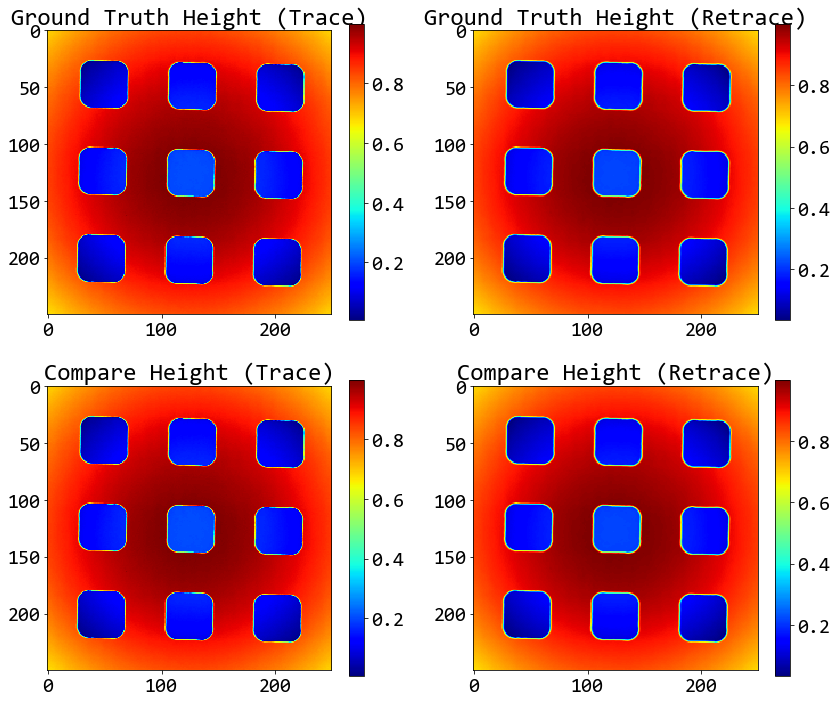

In [12]:
### Image Ground Truth
IMAGE_GT = DATA_GT[INDEX_GT, :, :, :].astype(np.float32)

print('IMAGE_GT : type = {0}, dtype = {1}, shape = {2}'
      .format(type(IMAGE_GT), IMAGE_GT.dtype, IMAGE_GT.shape))

### Image Compare
IMAGE_CMP = DATA_GT[INDEX_CMP, :, :, :].astype(np.float32)

print('IMAGE_CMP: type = {0}, dtype = {1}, shape = {2}'
      .format(type(IMAGE_CMP), IMAGE_CMP.dtype, IMAGE_CMP.shape))

# Display
plt.figure(figsize=(14, 12))

plt.subplot(2, 2, 1)
plt.imshow(IMAGE_GT[INDEX_TRACE, :, :], cmap=CMAP)
plt.title('Ground Truth ' + ALL_FIG_TITLE[INDEX_TRACE])
plt.colorbar()

plt.subplot(2, 2, 2)
plt.imshow(IMAGE_GT[INDEX_RETRACE, :, :], cmap=CMAP)
plt.title('Ground Truth ' + ALL_FIG_TITLE[INDEX_RETRACE])
plt.colorbar()

plt.subplot(2, 2, 3)
plt.imshow(IMAGE_CMP[INDEX_TRACE, :, :], cmap=CMAP)
plt.title('Compare ' + ALL_FIG_TITLE[INDEX_TRACE])
plt.colorbar()

plt.subplot(2, 2, 4)
plt.imshow(IMAGE_CMP[INDEX_RETRACE, :, :], cmap=CMAP)
plt.title('Compare ' + ALL_FIG_TITLE[INDEX_RETRACE])
plt.colorbar()

plt.show()

### Image Train

IMAGE_TRAIN_INPUT : type = <class 'numpy.ndarray'>, dtype = float32, shape = (4, 250, 250)
IMAGE_TRAIN_OUTPUT: type = <class 'numpy.ndarray'>, dtype = float32, shape = (250, 250)


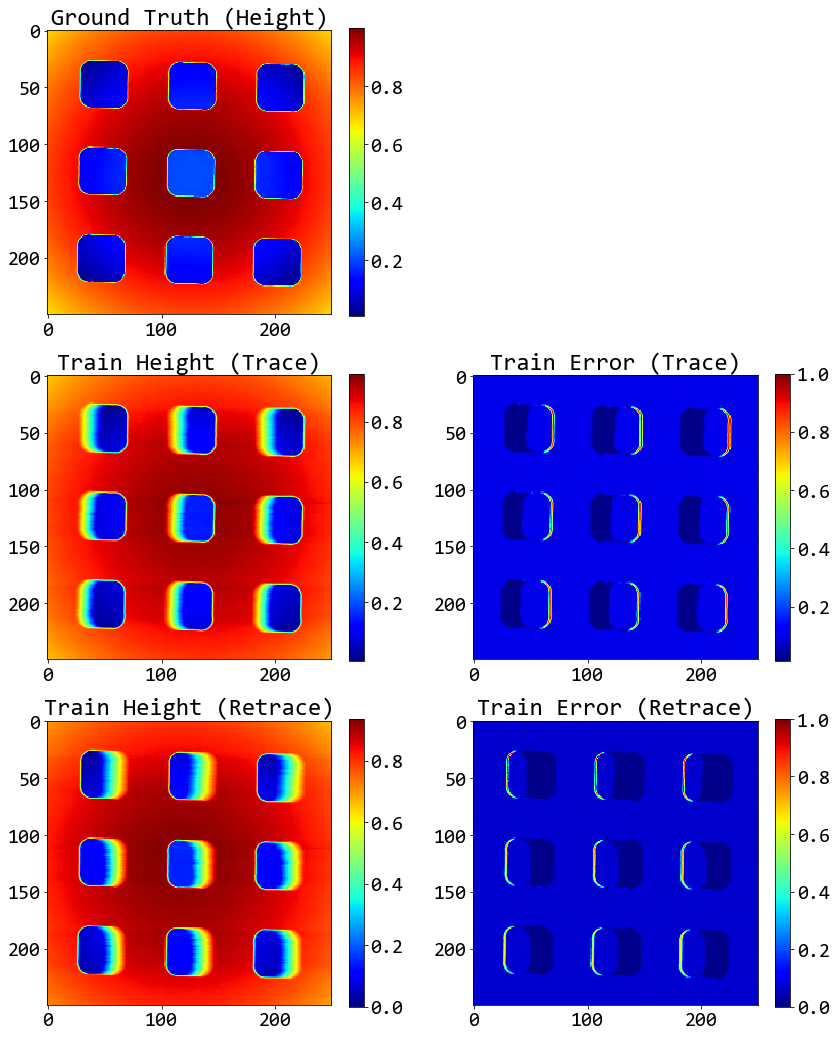

In [13]:
# ---------------------------------------------------------------- #
# -------------------- Input = Height + Error -------------------- #
# ---------------------------------------------------------------- #

IMAGE_TRAIN_INPUT = DATA_GT[INDEX_TRAIN, :, :, :].astype(np.float32)

print('IMAGE_TRAIN_INPUT : type = {0}, dtype = {1}, shape = {2}'
      .format(type(IMAGE_TRAIN_INPUT), IMAGE_TRAIN_INPUT.dtype, IMAGE_TRAIN_INPUT.shape))

# ---------------------------------------------------------------- #
# -------------------- Output = Ground Truth --------------------- #
# ---------------------------------------------------------------- #

IMAGE_TRAIN_OUTPUT = np.array(IMAGE_GT[INDEX_TRACE, :, :])

print('IMAGE_TRAIN_OUTPUT: type = {0}, dtype = {1}, shape = {2}'
      .format(type(IMAGE_TRAIN_OUTPUT), IMAGE_TRAIN_OUTPUT.dtype, IMAGE_TRAIN_OUTPUT.shape))

# ---------------------------------------------------------------- #
# --------------------------- Display ---------------------------- #
# ---------------------------------------------------------------- #

# Display
plt.figure(figsize=(14, 18))

plt.subplot(3, 2, 1)
plt.imshow(IMAGE_TRAIN_OUTPUT, cmap=CMAP)
plt.title('Ground Truth (Height)')
plt.colorbar()

for i in range(len(ALL_FIG_TITLE)):
    plt.subplot(3, 2, 3+i)
    plt.imshow(IMAGE_TRAIN_INPUT[i, :, :], cmap=CMAP)
    plt.title('Train ' + ALL_FIG_TITLE[i])
    plt.colorbar()

plt.show()

### Image Test

IMAGE_TEST_INPUT : type = <class 'numpy.ndarray'>, dtype = float32, shape = (4, 250, 250)
IMAGE_TEST_OUTPUT: type = <class 'numpy.ndarray'>, dtype = float32, shape = (250, 250)


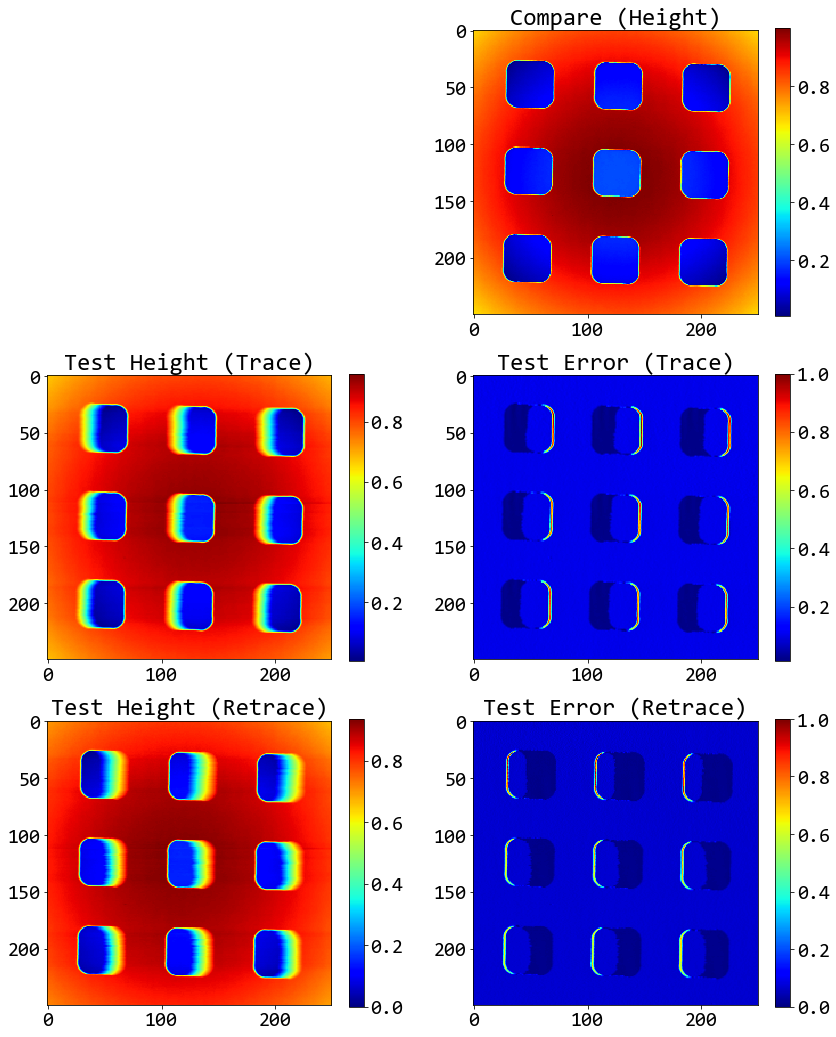

In [14]:
# ---------------------------------------------------------------- #
# -------------------- Input = Height + Error -------------------- #
# ---------------------------------------------------------------- #

IMAGE_TEST_INPUT = DATA_GT[INDEX_TEST, :, :, :].astype(np.float32)

print('IMAGE_TEST_INPUT : type = {0}, dtype = {1}, shape = {2}'
      .format(type(IMAGE_TEST_INPUT), IMAGE_TEST_INPUT.dtype, IMAGE_TEST_INPUT.shape))

# ---------------------------------------------------------------- #
# -------------------- Output = Ground Truth --------------------- #
# ---------------------------------------------------------------- #

IMAGE_TEST_OUTPUT = np.array(IMAGE_CMP[INDEX_TRACE, :, :])

print('IMAGE_TEST_OUTPUT: type = {0}, dtype = {1}, shape = {2}'
      .format(type(IMAGE_TEST_OUTPUT), IMAGE_TEST_OUTPUT.dtype, IMAGE_TEST_OUTPUT.shape))

# ---------------------------------------------------------------- #
# --------------------------- Display ---------------------------- #
# ---------------------------------------------------------------- #

# Display
plt.figure(figsize=(14, 18))

plt.subplot(3, 2, 2)
plt.imshow(IMAGE_TEST_OUTPUT, cmap=CMAP)
plt.title('Compare (Height)')
plt.colorbar()

for i in range(len(ALL_FIG_TITLE)):
    plt.subplot(3, 2, 3+i)
    plt.imshow(IMAGE_TEST_INPUT[i, :, :], cmap=CMAP)
    plt.title('Test ' + ALL_FIG_TITLE[i])
    plt.colorbar()

plt.show()

### Sampling Positions

In [15]:
### ---------------- Automatic u-path sampling ---------------- ###
### ------ first-order derivatives of topographic images ------ ###

# # ---------------------------------------------------------------- #
# # -------------------------- TRAIN_POS --------------------------- #
# # ---------------------------------------------------------------- #

# ### Method_1

# SUB_SAMPLE_Ls = []
# row_interval  = 11
# col_half_len  = 72

# # IMAGE_CLACULATION = IMAGE_TRAIN_OUTPUT
# IMAGE_CLACULATION = np.average([IMAGE_TRAIN_INPUT[INDEX_TRACE], IMAGE_TRAIN_INPUT[INDEX_RETRACE]], axis=0)

# for row in np.arange( NN_KERNEL_H//2+row_interval//2, 
#                      -NN_KERNEL_H//2+np.shape(IMAGE_TRAIN_OUTPUT)[0]-1, row_interval):
#     ### Data diff
#     col_data = IMAGE_CLACULATION[row, :]
#     col_diff = np.abs(col_data[1:] - col_data[:-1])
        
#     ### Max or Min    
#     if row // row_interval % 2 == 0:
#         # Max changing
#         col_center = np.argmax(col_diff)
#     else:
#         # Min changing
#         col_center  = np.argmin(col_diff)

#     ### Start and End
#     col_s = np.max([col_center - col_half_len,  NN_KERNEL_W//2])
#     col_e = np.min([col_center + col_half_len, -NN_KERNEL_W//2+np.shape(IMAGE_TRAIN_OUTPUT)[1]-1])

#     SUB_SAMPLE_Ls.append([row, col_s, col_e])
# #     print([row, col_s, row, col_e])

# # ---------------------------------------------------------------- #
# # ---------------------------- HALCON ---------------------------- #
# # ---------------------------------------------------------------- #

# for sample in SUB_SAMPLE_Ls:
#     print('gen_rectangle1 (Rectangle, {0}, {1}, {2}, {3})'.format(sample[0], sample[1], sample[0], sample[2]))
#     print('concat_obj (EmptyObject, Rectangle, EmptyObject)')

TRAIN_POS: 1840 samples


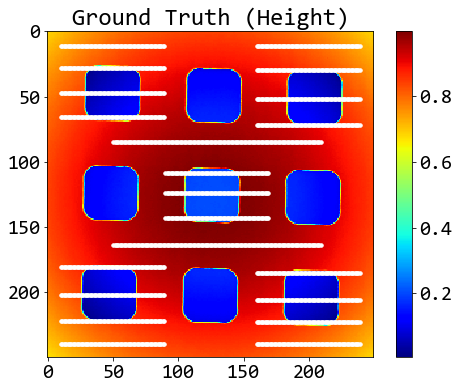

In [16]:
# ---------------------------------------------------------------- #
# -------------------------- TRAIN_POS --------------------------- #
# ---------------------------------------------------------------- #

### TRAIN_POS (need to remove the border positions)
if SAMPLE_METHOD == 0:
    ### Version 0: full sampling
    SUB_SAMPLE_H = DATA_GT_H - NN_KERNEL_H + 1
    SUB_SAMPLE_W = DATA_GT_W - NN_KERNEL_W + 1
    
    TRAIN_POS = [[r, c] for r in range(NN_KERNEL_H//2, DATA_GT_H - NN_KERNEL_H//2) 
                        for c in range(NN_KERNEL_W//2, DATA_GT_W - NN_KERNEL_W//2)]
elif SAMPLE_METHOD == 1:
    ### Version 1: point sub sampling
    FRE_H = DATA_GT_H // SUB_SAMPLE_H
    FRE_W = DATA_GT_W // SUB_SAMPLE_W
    TRAIN_POS = [[r, c] for r in np.linspace(FRE_H, DATA_GT_H-FRE_H-1, SUB_SAMPLE_H, dtype=np.int32)
                        for c in np.linspace(FRE_W, DATA_GT_W-FRE_W-1, SUB_SAMPLE_W, dtype=np.int32)]
elif SAMPLE_METHOD == 2:
    ### Version 2: line sub sampling
    FRE_H        = DATA_GT_H // SUB_SAMPLE_H // 2
    SUB_SAMPLE_W = DATA_GT_W - NN_KERNEL_W + 1
    
    TRAIN_POS = [[r, c] for r in np.linspace(FRE_H, DATA_GT_H-FRE_H-1, SUB_SAMPLE_H, dtype=np.int32) 
                        for c in range(NN_KERNEL_W//2+5, DATA_GT_W - NN_KERNEL_W//2-5)]
elif SAMPLE_METHOD == 3:
    ### Version 3: short line sub sampling
    TRAIN_POS = []
    for sub_sample_l in SUB_SAMPLE_Ls:
        TRAIN_POS.extend([[r, c] for r in [sub_sample_l[0]] for c in range(sub_sample_l[1], sub_sample_l[2])])
     
### Display
print('TRAIN_POS: {0} samples'.format(len(TRAIN_POS)))

plt.figure(figsize=(8, 6))
plt.imshow(IMAGE_TRAIN_OUTPUT, cmap=CMAP)
plt.title('Ground Truth (Height)')
plt.colorbar()
plt.scatter([pos[1] for pos in TRAIN_POS], [pos[0] for pos in TRAIN_POS], color = 'white', s=12)
plt.show()

### URL of tfrecord

In [17]:
# ---------------------------------------------------------------- #
# ------------------------ Output Folder ------------------------- #
# ---------------------------------------------------------------- #

if SAMPLE_METHOD == 0 or SAMPLE_METHOD == 1 or SAMPLE_METHOD == 2:
    OUTPUT_NAME = FILE_TITLE + ' {0} {1}x{2} {3}x{4}x{5} {6}x{7}x{8} {9}x{10}'
    OUTPUT_NAME = OUTPUT_NAME.format(NETWORK, 
                                     DATA_GT_H, DATA_GT_W, 
                                     SAMPLE_METHOD, SUB_SAMPLE_H, SUB_SAMPLE_W, 
                                     NN_KERNEL_D, NN_KERNEL_H, NN_KERNEL_W, 
                                     INDEX_GT, INDEX_TRAIN)
elif SAMPLE_METHOD == 3:
    OUTPUT_NAME = FILE_TITLE + ' {0} {1}x{2} {3}x{4}x{5} {6}x{7}x{8} {9}x{10}'
    OUTPUT_NAME = OUTPUT_NAME.format(NETWORK, 
                                     DATA_GT_H, DATA_GT_W, 
                                     SAMPLE_METHOD, len(SUB_SAMPLE_Ls), len(TRAIN_POS), 
                                     NN_KERNEL_D, NN_KERNEL_H, NN_KERNEL_W, 
                                     INDEX_GT, INDEX_TRAIN)

OUTPUT_URL  = os.path.join(ROOT_URL, 'output', OUTPUT_NAME)
os.makedirs(OUTPUT_URL, exist_ok=True)

print(OUTPUT_URL)

# ---------------------------------------------------------------- #
# ------------------------- tfrecord Url ------------------------- #
# ---------------------------------------------------------------- #

TRAIN_TFR_URL = os.path.join(OUTPUT_URL, 'train.tfrecord')

# ---------------------------------------------------------------- #
# ----------------------- Fitted Data Url ------------------------ #
# ---------------------------------------------------------------- #

NN_FITTED_DATA_NPY_URL = os.path.join(OUTPUT_URL, 'nn_fitted_data.npy')

# ---------------------------------------------------------------- #
# ---------------------- Analysis Data Url ----------------------- #
# ---------------------------------------------------------------- #

ANLS_URL = os.path.join(OUTPUT_URL, 'anls')
os.makedirs(ANLS_URL, exist_ok=True)

output\silicon net_5x5 250x250 3x21x1840 4x5x5 0x3


### TF Record (Flg)

In [18]:
if True:    # True OR False
    ### Random only for train
    np.random.seed(0)
    np.random.shuffle(TRAIN_POS)
  
    # ---------------------------------------------------------------- #
    # ------------------------- Training Set ------------------------- #
    # ---------------------------------------------------------------- #
    
    with tqdm(desc='Training Set', total=np.shape(TRAIN_POS)[0]) as pbar:
        ### Create tfrecord
        train_writer = tf.python_io.TFRecordWriter(TRAIN_TFR_URL)

        ### Loop
        for pixel in TRAIN_POS:            
            row = pixel[0]
            col = pixel[1]

            ### Generate data
            data_n = '{0}_{1}'.format(row, col)
            data_x = IMAGE_TRAIN_INPUT[:, 
                                       row-NN_KERNEL_H//2:row+NN_KERNEL_H//2+1, 
                                       col-NN_KERNEL_W//2:col+NN_KERNEL_W//2+1]
            data_y = IMAGE_TRAIN_OUTPUT[row, col]

            ### Reshape to a vector
            data_x = data_x.reshape(-1)
            data_y = data_y.reshape(-1)

            ### example: (data_n, data_x, data_y)
            example = tf.train.Example(
                        features = tf.train.Features(feature = {
                                'data_n': tf.train.Feature(bytes_list = tf.train.BytesList(value = [data_n.encode()])), 
                                'data_x': tf.train.Feature(bytes_list = tf.train.BytesList(value = [data_x.tobytes()])), 
                                'data_y': tf.train.Feature(bytes_list = tf.train.BytesList(value = [data_y.tobytes()])), 
                                }))

            ### Add example
            train_writer.write(example.SerializeToString())

            ### Update
            pbar.update(1)

        ### Close
        train_writer.close()  

Training Set: 100%|██████████████████████████████████████████████████████████████| 1840/1840 [00:00<00:00, 9821.18it/s]


## Neural Network

### Get Data

In [19]:
def get_batches(tfr_url, batch_size, is_training=True, num_threads=4, capacity=1024.0, min_after_dequeue=256):
    """ Get tfrecord batches. 

        Args: 
            tfr_url          : The url of .tfrecord files.
            batch_size       : Training parameter, batch size. 
            is_training      : If Ture, use tf.train.shuffle_batch for training, else, use tf.train.batch for testing. 
            num_threads      : 
            capacity         : 
            min_after_dequeue: 

        Return: 
            data_dicts: {data_n:data_n, data_x:data_x, data_y:data_y}

        Raises:
            ValueError('Cannot find the .tfrecord files. ')

        Notes:
            None.
    """
    ### Is .tfrecord files exists?
    if not os.path.exists(tfr_url):
        raise ValueError('Cannot find the .tfrecord files. ')

    ### Define the filename_queue and serialized_example
    filename_queue        = tf.train.string_input_producer([tfr_url], capacity=capacity)
    reader                = tf.TFRecordReader()
    _, serialized_example = reader.read(filename_queue)

    ### Decode the example
    features = tf.parse_single_example(serialized_example, 
                    features = {'data_n' :tf.FixedLenFeature([], tf.string), 
                                'data_x' :tf.FixedLenFeature([], tf.string),
                                'data_y' :tf.FixedLenFeature([], tf.string),
                               })

    ### Get the detail datas
    data_n = tf.cast(features['data_n'],       tf.string)
    data_x = tf.decode_raw(features['data_x'], tf.float32)
    data_y = tf.decode_raw(features['data_y'], tf.float32)

    ### Reshape data, if not, a undefined shape of tensor will be thrown. 
    data_x = tf.divide(tf.reshape(data_x, [ INPUT_CNT]), DATA_SCALE_IN)
    data_y = tf.divide(tf.reshape(data_y, [OUTPUT_CNT]), DATA_SCALE_OUT)
    
    ### Get data dict
    data_dict = {'data_n': data_n, 
                 'data_x': data_x, 
                 'data_y': data_y, 
                }

    ### Get the batches
    if is_training:     # For training
        data_dicts = tf.train.shuffle_batch(data_dict, batch_size, capacity, min_after_dequeue, num_threads=num_threads)
    
    else:               # For test
        data_dicts = tf.train.batch(data_dict, batch_size)

    ### Return
    return data_dicts

### Get Kernel Size

In [20]:
def get_kernel_size(crop_h, crop_w):
    """ Get kernel size. 

        Args: 
            crop_h: (>= 3) must be odd, e.g. h = 5
            crop_w: (>= 3) must be odd, e.g. w = 7

        Return: 
            kernels: [[3, 3], [3, 5], [3, 7], [5, 3], [5, 5], [5, 7]]

        Raises:
            None.
    """
    ### The input number must be odd. 
    if (crop_h < 3 or crop_h % 2 != 1) or (crop_w < 3 or crop_w % 2 != 1):
        raise ValueError('The input number is not an odd number greater than 2. ')
        
    ### Loop h and w
    kernels = []
    for h in range(3, crop_h+1, 2):
        for w in range(3, crop_w+1, 2):
            kernels.append([h, w])
            
    ### Return
    return kernels

### net_3x3

In [21]:
def net_3x3(inputs, num_classes, is_training=True, dropout_keep_prob=0.8, reuse=tf.AUTO_REUSE, scope='net_3x3'):
    """ A DCNN architecture. 

        Inputs --> [NN_KERNEL_H x NN_KERNEL_W] 
               --> [5 x 5 x 8] --> [5 x 5 x 32] --> [5 x 5 x 256] 
               --> [1 x 1 x 256] --> [256] --> [16] --> [1]

        Args: 
            inputs           : The input data sets whose shape likes [25]. 
            num_classes      : The number of output classes. 
            is_training      : Is training, if yes, it will ignore dropout_keep_prob.  
            dropout_keep_prob: The value of dropout parameter. 
            reuse            : 
            scope            :

        Return: 
            net: The output of the net which do not input tf.nn.softmax. 

        Raises:
            None.

        Notes:
            None.
    """
    with tf.variable_scope(scope, 'net_1', [inputs], reuse=reuse):
        ### Reshape
        with tf.variable_scope('layer0'):
            net = tf.reshape(inputs, [-1, NN_KERNEL_H, NN_KERNEL_W, NN_KERNEL_D], name='reshape')
            
        ### Convolution
        with tf.variable_scope('layer_3x3'):
            net = slim.conv2d(net,  4, [3, 3],                  scope='conv_1')
            net = slim.conv2d(net, 16, [3, 3], padding='VALID', scope='conv_2')
            net = tf.reshape(net, [-1, 16], name='reshape')

        ### Full Connection
        with tf.variable_scope('layer_fc'):
            net = slim.fully_connected(net, 4, scope='fc1')
            net = slim.fully_connected(net, num_classes, activation_fn=None, scope='fc2')
            
        ### return
        return net

### net_5x5

In [22]:
def net_5x5(inputs, num_classes, is_training=True, dropout_keep_prob=0.8, reuse=tf.AUTO_REUSE, scope='net_5x5'):
    """ A DCNN architecture. 

        Inputs --> [NN_KERNEL_H x NN_KERNEL_W] 
               --> [5 x 5 x 8] --> [5 x 5 x 32] --> [5 x 5 x 256] 
               --> [1 x 1 x 256] --> [256] --> [16] --> [1]

        Args: 
            inputs           : The input data sets whose shape likes [25]. 
            num_classes      : The number of output classes. 
            is_training      : Is training, if yes, it will ignore dropout_keep_prob.  
            dropout_keep_prob: The value of dropout parameter. 
            reuse            : 
            scope            :

        Return: 
            net: The output of the net which do not input tf.nn.softmax. 

        Raises:
            None.

        Notes:
            None.
    """
    with tf.variable_scope(scope, 'net_1', [inputs], reuse=reuse):
        ### Reshape
        with tf.variable_scope('layer0'):
            net = tf.reshape(inputs, [-1, NN_KERNEL_H, NN_KERNEL_W, NN_KERNEL_D], name='reshape')
            
        ### 3x3: Convolution
        with tf.variable_scope('layer_3x3'):
            begin = [ 0, 1, 1,  0]
            size  = [-1, 3, 3, -1]
            net_3x3 = tf.slice(net, begin, size, name='slice')
            net_3x3 = slim.conv2d(net_3x3,  4, size[1:3],                  scope='conv_1')
            net_3x3 = slim.conv2d(net_3x3, 16, size[1:3], padding='VALID', scope='conv_2')
            net_3x3 = tf.reshape(net_3x3, [-1, 16], name='reshape')
    
        ### 3x5: Convolution
        with tf.variable_scope('layer_3x5'):
            begin = [ 0, 1, 0,  0]
            size  = [-1, 3, 5, -1]
            net_3x5 = tf.slice(net, begin, size, name='slice')
            net_3x5 = slim.conv2d(net_3x5,  4, size[1:3],                  scope='conv_1')
            net_3x5 = slim.conv2d(net_3x5, 16, size[1:3], padding='VALID', scope='conv_2')
            net_3x5 = tf.reshape(net_3x5, [-1, 16], name='reshape')

        ### 5x3: Convolution
        with tf.variable_scope('layer_5x3'):
            begin = [ 0, 0, 1,  0]
            size  = [-1, 5, 3, -1]
            net_5x3 = tf.slice(net, begin, size, name='slice')
            net_5x3 = slim.conv2d(net_5x3,  4, size[1:3],                  scope='conv_1')
            net_5x3 = slim.conv2d(net_5x3, 16, size[1:3], padding='VALID', scope='conv_2')
            net_5x3 = tf.reshape(net_5x3, [-1, 16], name='reshape')

        ### 5x5: Convolution
        with tf.variable_scope('layer_5x5'):
            begin = [ 0, 0, 0,  0]
            size  = [-1, 5, 5, -1]
            net_5x5 = tf.slice(net, begin, size, name='slice')
            net_5x5 = slim.conv2d(net_5x5,  4, size[1:3],                  scope='conv_1')
            net_5x5 = slim.conv2d(net_5x5, 16, size[1:3], padding='VALID', scope='conv_2')
            net_5x5 = tf.reshape(net_5x5, [-1, 16], name='reshape')

        ### Concat
        with tf.variable_scope('layer_concat'):
            net = tf.concat([net_3x3, net_3x5, net_5x3, net_5x5], axis=1, name='concat')
            net = slim.dropout(net, keep_prob=dropout_keep_prob, scope='dropout')
            
        ### Full Connection
        with tf.variable_scope('layer_fc'):
            net = slim.fully_connected(net, 8, scope='fc1')
            net = slim.fully_connected(net, num_classes, activation_fn=None, scope='fc2')
            
        ### return
        return net

### net_7x7

In [23]:
def net_7x7(inputs, num_classes, is_training=True, dropout_keep_prob=0.8, reuse=tf.AUTO_REUSE, scope='net_7x7'):
    """ A DCNN architecture. 

        Inputs --> [NN_KERNEL_H x NN_KERNEL_W] 
               --> [5 x 5 x 8] --> [5 x 5 x 32] --> [5 x 5 x 256] 
               --> [1 x 1 x 256] --> [256] --> [16] --> [1]

        Args: 
            inputs           : The input data sets whose shape likes [25]. 
            num_classes      : The number of output classes. 
            is_training      : Is training, if yes, it will ignore dropout_keep_prob.  
            dropout_keep_prob: The value of dropout parameter. 
            reuse            : 
            scope            :

        Return: 
            net: The output of the net which do not input tf.nn.softmax. 

        Raises:
            None.

        Notes:
            None.
    """
    with tf.variable_scope(scope, 'net_1', [inputs], reuse=reuse):
        ### Reshape
        with tf.variable_scope('layer0'):
            net = tf.reshape(inputs, [-1, NN_KERNEL_H, NN_KERNEL_W, NN_KERNEL_D], name='reshape')
            
        ### 3x3: Convolution
        with tf.variable_scope('layer_3x3'):
            begin = [ 0, 2, 2,  0]
            size  = [-1, 3, 3, -1]
            net_3x3 = tf.slice(net, begin, size, name='slice')
            net_3x3 = slim.conv2d(net_3x3,  4, size[1:3],                  scope='conv_1')
            net_3x3 = slim.conv2d(net_3x3, 16, size[1:3], padding='VALID', scope='conv_2')
            net_3x3 = tf.reshape(net_3x3, [-1, 16], name='reshape')
    
        ### 3x5: Convolution
        with tf.variable_scope('layer_3x5'):
            begin = [ 0, 2, 1,  0]
            size  = [-1, 3, 5, -1]
            net_3x5 = tf.slice(net, begin, size, name='slice')
            net_3x5 = slim.conv2d(net_3x5,  4, size[1:3],                  scope='conv_1')
            net_3x5 = slim.conv2d(net_3x5, 16, size[1:3], padding='VALID', scope='conv_2')
            net_3x5 = tf.reshape(net_3x5, [-1, 16], name='reshape')
            
        ### 3x7: Convolution
        with tf.variable_scope('layer_3x7'):
            begin = [ 0, 2, 0,  0]
            size  = [-1, 3, 7, -1]
            net_3x7 = tf.slice(net, begin, size, name='slice')
            net_3x7 = slim.conv2d(net_3x7,  4, size[1:3],                  scope='conv_1')
            net_3x7 = slim.conv2d(net_3x7, 16, size[1:3], padding='VALID', scope='conv_2')
            net_3x7 = tf.reshape(net_3x7, [-1, 16], name='reshape')

        ### 5x3: Convolution
        with tf.variable_scope('layer_5x3'):
            begin = [ 0, 1, 2,  0]
            size  = [-1, 5, 3, -1]
            net_5x3 = tf.slice(net, begin, size, name='slice')
            net_5x3 = slim.conv2d(net_5x3,  4, size[1:3],                  scope='conv_1')
            net_5x3 = slim.conv2d(net_5x3, 16, size[1:3], padding='VALID', scope='conv_2')
            net_5x3 = tf.reshape(net_5x3, [-1, 16], name='reshape')

        ### 5x5: Convolution
        with tf.variable_scope('layer_5x5'):
            begin = [ 0, 1, 1,  0]
            size  = [-1, 5, 5, -1]
            net_5x5 = tf.slice(net, begin, size, name='slice')
            net_5x5 = slim.conv2d(net_5x5,  4, size[1:3],                  scope='conv_1')
            net_5x5 = slim.conv2d(net_5x5, 16, size[1:3], padding='VALID', scope='conv_2')
            net_5x5 = tf.reshape(net_5x5, [-1, 16], name='reshape')
            
        ### 5x7: Convolution
        with tf.variable_scope('layer_5x7'):
            begin = [ 0, 1, 0,  0]
            size  = [-1, 5, 7, -1]
            net_5x7 = tf.slice(net, begin, size, name='slice')
            net_5x7 = slim.conv2d(net_5x7,  4, size[1:3],                  scope='conv_1')
            net_5x7 = slim.conv2d(net_5x7, 16, size[1:3], padding='VALID', scope='conv_2')
            net_5x7 = tf.reshape(net_5x7, [-1, 16], name='reshape')
            
        ### 7x3: Convolution
        with tf.variable_scope('layer_7x3'):
            begin = [ 0, 0, 2,  0]
            size  = [-1, 7, 3, -1]
            net_7x3 = tf.slice(net, begin, size, name='slice')
            net_7x3 = slim.conv2d(net_7x3,  4, size[1:3],                  scope='conv_1')
            net_7x3 = slim.conv2d(net_7x3, 16, size[1:3], padding='VALID', scope='conv_2')
            net_7x3 = tf.reshape(net_7x3, [-1, 16], name='reshape')

        ### 7x5: Convolution
        with tf.variable_scope('layer_7x5'):
            begin = [ 0, 0, 1,  0]
            size  = [-1, 7, 5, -1]
            net_7x5 = tf.slice(net, begin, size, name='slice')
            net_7x5 = slim.conv2d(net_7x5,  4, size[1:3],                  scope='conv_1')
            net_7x5 = slim.conv2d(net_7x5, 16, size[1:3], padding='VALID', scope='conv_2')
            net_7x5 = tf.reshape(net_7x5, [-1, 16], name='reshape')
            
        ### 7x7: Convolution
        with tf.variable_scope('layer_7x7'):
            begin = [ 0, 0, 0,  0]
            size  = [-1, 7, 7, -1]
            net_7x7 = tf.slice(net, begin, size, name='slice')
            net_7x7 = slim.conv2d(net_7x7,  4, size[1:3],                  scope='conv_1')
            net_7x7 = slim.conv2d(net_7x7, 16, size[1:3], padding='VALID', scope='conv_2')
            net_7x7 = tf.reshape(net_7x7, [-1, 16], name='reshape')

        ### Concat
        with tf.variable_scope('layer_concat'):
            net = tf.concat([net_3x3, net_3x5, net_3x7, 
                             net_5x3, net_5x5, net_5x7, 
                             net_7x3, net_7x5, net_7x7], axis=1, name='concat')
            net = slim.dropout(net, keep_prob=dropout_keep_prob, scope='dropout')

        ### Full Connection
        with tf.variable_scope('layer_fc'):
            net = slim.fully_connected(net, 8, scope='fc1')
            net = slim.fully_connected(net, num_classes, activation_fn=None, scope='fc2')
            
        ### return
        return net

### net_9x9

In [24]:
def net_9x9(inputs, num_classes, is_training=True, dropout_keep_prob=0.8, reuse=tf.AUTO_REUSE, scope='net_9x9'):
    """ A DCNN architecture. 

        Inputs --> [NN_KERNEL_H x NN_KERNEL_W] 
               --> [5 x 5 x 8] --> [5 x 5 x 32] --> [5 x 5 x 256] 
               --> [1 x 1 x 256] --> [256] --> [16] --> [1]

        Args: 
            inputs           : The input data sets whose shape likes [25]. 
            num_classes      : The number of output classes. 
            is_training      : Is training, if yes, it will ignore dropout_keep_prob.  
            dropout_keep_prob: The value of dropout parameter. 
            reuse            : 
            scope            :

        Return: 
            net: The output of the net which do not input tf.nn.softmax. 

        Raises:
            None.

        Notes:
            None.
    """
    with tf.variable_scope(scope, 'net_1', [inputs], reuse=reuse):
        ### Reshape
        with tf.variable_scope('layer0'):
            net = tf.reshape(inputs, [-1, NN_KERNEL_H, NN_KERNEL_W, NN_KERNEL_D], name='reshape')
            
        ### 3x3: Convolution
        with tf.variable_scope('layer_3x3'):
            begin = [ 0, 3, 3,  0]
            size  = [-1, 3, 3, -1]
            net_3x3 = tf.slice(net, begin, size, name='slice')
            net_3x3 = slim.conv2d(net_3x3,  4, size[1:3],                  scope='conv_1')
            net_3x3 = slim.conv2d(net_3x3, 16, size[1:3], padding='VALID', scope='conv_2')
            net_3x3 = tf.reshape(net_3x3, [-1, 16], name='reshape')
    
        ### 3x5: Convolution
        with tf.variable_scope('layer_3x5'):
            begin = [ 0, 3, 2,  0]
            size  = [-1, 3, 5, -1]
            net_3x5 = tf.slice(net, begin, size, name='slice')
            net_3x5 = slim.conv2d(net_3x5,  4, size[1:3],                  scope='conv_1')
            net_3x5 = slim.conv2d(net_3x5, 16, size[1:3], padding='VALID', scope='conv_2')
            net_3x5 = tf.reshape(net_3x5, [-1, 16], name='reshape')
            
        ### 3x7: Convolution
        with tf.variable_scope('layer_3x7'):
            begin = [ 0, 3, 1,  0]
            size  = [-1, 3, 7, -1]
            net_3x7 = tf.slice(net, begin, size, name='slice')
            net_3x7 = slim.conv2d(net_3x7,  4, size[1:3],                  scope='conv_1')
            net_3x7 = slim.conv2d(net_3x7, 16, size[1:3], padding='VALID', scope='conv_2')
            net_3x7 = tf.reshape(net_3x7, [-1, 16], name='reshape')

        ### 3x9: Convolution
        with tf.variable_scope('layer_3x9'):
            begin = [ 0, 3, 0,  0]
            size  = [-1, 3, 9, -1]
            net_3x9 = tf.slice(net, begin, size, name='slice')
            net_3x9 = slim.conv2d(net_3x9,  4, size[1:3],                  scope='conv_1')
            net_3x9 = slim.conv2d(net_3x9, 16, size[1:3], padding='VALID', scope='conv_2')
            net_3x9 = tf.reshape(net_3x9, [-1, 16], name='reshape')
            
        ### 5x3: Convolution
        with tf.variable_scope('layer_5x3'):
            begin = [ 0, 2, 3,  0]
            size  = [-1, 5, 3, -1]
            net_5x3 = tf.slice(net, begin, size, name='slice')
            net_5x3 = slim.conv2d(net_5x3,  4, size[1:3],                  scope='conv_1')
            net_5x3 = slim.conv2d(net_5x3, 16, size[1:3], padding='VALID', scope='conv_2')
            net_5x3 = tf.reshape(net_5x3, [-1, 16], name='reshape')

        ### 5x5: Convolution
        with tf.variable_scope('layer_5x5'):
            begin = [ 0, 2, 2,  0]
            size  = [-1, 5, 5, -1]
            net_5x5 = tf.slice(net, begin, size, name='slice')
            net_5x5 = slim.conv2d(net_5x5,  4, size[1:3],                  scope='conv_1')
            net_5x5 = slim.conv2d(net_5x5, 16, size[1:3], padding='VALID', scope='conv_2')
            net_5x5 = tf.reshape(net_5x5, [-1, 16], name='reshape')

        ### 5x7: Convolution
        with tf.variable_scope('layer_5x7'):
            begin = [ 0, 2, 1,  0]
            size  = [-1, 5, 7, -1]
            net_5x7 = tf.slice(net, begin, size, name='slice')
            net_5x7 = slim.conv2d(net_5x7,  4, size[1:3],                  scope='conv_1')
            net_5x7 = slim.conv2d(net_5x7, 16, size[1:3], padding='VALID', scope='conv_2')
            net_5x7 = tf.reshape(net_5x7, [-1, 16], name='reshape')

        ### 5x9: Convolution
        with tf.variable_scope('layer_5x9'):
            begin = [ 0, 2, 0,  0]
            size  = [-1, 5, 9, -1]
            net_5x9 = tf.slice(net, begin, size, name='slice')
            net_5x9 = slim.conv2d(net_5x9,  4, size[1:3],                  scope='conv_1')
            net_5x9 = slim.conv2d(net_5x9, 16, size[1:3], padding='VALID', scope='conv_2')
            net_5x9 = tf.reshape(net_5x9, [-1, 16], name='reshape')    
            
        ### 7x3: Convolution
        with tf.variable_scope('layer_7x3'):
            begin = [ 0, 1, 3,  0]
            size  = [-1, 7, 3, -1]
            net_7x3 = tf.slice(net, begin, size, name='slice')
            net_7x3 = slim.conv2d(net_7x3,  4, size[1:3],                  scope='conv_1')
            net_7x3 = slim.conv2d(net_7x3, 16, size[1:3], padding='VALID', scope='conv_2')
            net_7x3 = tf.reshape(net_7x3, [-1, 16], name='reshape')

        ### 7x5: Convolution
        with tf.variable_scope('layer_7x5'):
            begin = [ 0, 1, 2,  0]
            size  = [-1, 7, 5, -1]
            net_7x5 = tf.slice(net, begin, size, name='slice')
            net_7x5 = slim.conv2d(net_7x5,  4, size[1:3],                  scope='conv_1')
            net_7x5 = slim.conv2d(net_7x5, 16, size[1:3], padding='VALID', scope='conv_2')
            net_7x5 = tf.reshape(net_7x5, [-1, 16], name='reshape')

        ### 7x7: Convolution
        with tf.variable_scope('layer_7x7'):
            begin = [ 0, 1, 1,  0]
            size  = [-1, 7, 7, -1]
            net_7x7 = tf.slice(net, begin, size, name='slice')
            net_7x7 = slim.conv2d(net_7x7,  4, size[1:3],                  scope='conv_1')
            net_7x7 = slim.conv2d(net_7x7, 16, size[1:3], padding='VALID', scope='conv_2')
            net_7x7 = tf.reshape(net_7x7, [-1, 16], name='reshape')

        ### 7x9: Convolution
        with tf.variable_scope('layer_7x9'):
            begin = [ 0, 1, 0,  0]
            size  = [-1, 7, 9, -1]
            net_7x9 = tf.slice(net, begin, size, name='slice')
            net_7x9 = slim.conv2d(net_7x9,  4, size[1:3],                  scope='conv_1')
            net_7x9 = slim.conv2d(net_7x9, 16, size[1:3], padding='VALID', scope='conv_2')
            net_7x9 = tf.reshape(net_7x9, [-1, 16], name='reshape')
            
        ### 9x3: Convolution
        with tf.variable_scope('layer_9x3'):
            begin = [ 0, 0, 3,  0]
            size  = [-1, 9, 3, -1]
            net_9x3 = tf.slice(net, begin, size, name='slice')
            net_9x3 = slim.conv2d(net_9x3,  4, size[1:3],                  scope='conv_1')
            net_9x3 = slim.conv2d(net_9x3, 16, size[1:3], padding='VALID', scope='conv_2')
            net_9x3 = tf.reshape(net_9x3, [-1, 16], name='reshape')

        ### 9x5: Convolution
        with tf.variable_scope('layer_9x5'):
            begin = [ 0, 0, 2,  0]
            size  = [-1, 9, 5, -1]
            net_9x5 = tf.slice(net, begin, size, name='slice')
            net_9x5 = slim.conv2d(net_9x5,  4, size[1:3],                  scope='conv_1')
            net_9x5 = slim.conv2d(net_9x5, 16, size[1:3], padding='VALID', scope='conv_2')
            net_9x5 = tf.reshape(net_9x5, [-1, 16], name='reshape')

        ### 9x7: Convolution
        with tf.variable_scope('layer_9x7'):
            begin = [ 0, 0, 1,  0]
            size  = [-1, 9, 7, -1]
            net_9x7 = tf.slice(net, begin, size, name='slice')
            net_9x7 = slim.conv2d(net_9x7,  4, size[1:3],                  scope='conv_1')
            net_9x7 = slim.conv2d(net_9x7, 16, size[1:3], padding='VALID', scope='conv_2')
            net_9x7 = tf.reshape(net_9x7, [-1, 16], name='reshape')

        ### 9x9: Convolution
        with tf.variable_scope('layer_9x9'):
            begin = [ 0, 0, 0,  0]
            size  = [-1, 9, 9, -1]
            net_9x9 = tf.slice(net, begin, size, name='slice')
            net_9x9 = slim.conv2d(net_9x9,  4, size[1:3],                  scope='conv_1')
            net_9x9 = slim.conv2d(net_9x9, 16, size[1:3], padding='VALID', scope='conv_2')
            net_9x9 = tf.reshape(net_9x9, [-1, 16], name='reshape')

        ### Concat
        with tf.variable_scope('layer_concat'):
            net = tf.concat([net_3x3, net_3x5, net_3x7, net_3x9, 
                             net_5x3, net_5x5, net_5x7, net_5x9,  
                             net_7x3, net_7x5, net_7x7, net_7x9, 
                             net_9x3, net_9x5, net_9x7, net_9x9], axis=1, name='concat')
            net = slim.dropout(net, keep_prob=dropout_keep_prob, scope='dropout')
            
        ### Full Connection
        with tf.variable_scope('layer_fc'):
            net = slim.fully_connected(net, 8, scope='fc1')
            net = slim.fully_connected(net, num_classes, activation_fn=None, scope='fc2')
            
        ### return
        return net

### Params (Flg)

In [25]:
# ---------------------------------------------------------------- # 
# ---------------------------- Flags ----------------------------- # 
# ---------------------------------------------------------------- # 

# True OR False
IS_TRAINING = True
IS_TEST     = True

# ---------------------------------------------------------------- # 
# ------------------------ NN Parameters ------------------------- # 
# ---------------------------------------------------------------- # 

### TRAINING
ITERATION_STEP    = 24000
BATCH_SIZE        = 64
LEARNING_RATE     = 0.00001
DROPOUT_KEEP_PROB = 1.0

### Graph

In [26]:
# ---------------------------------------------------------------- # 
# ------------------------- Define Graph ------------------------- # 
# ---------------------------------------------------------------- # 

with tf.Graph().as_default() as graph:
    ### Get batches
    if IS_TRAINING:
        train_data = get_batches(TRAIN_TFR_URL, batch_size=BATCH_SIZE, is_training=True)
        
    if IS_TEST:
        # test_data  = get_batches(TEST_TFR_URL, batch_size=1, is_training=False)
        pass
    
    ### placeholder
    is_training  = tf.placeholder(tf.bool, name='is_training')
    batch_data_x = tf.placeholder(tf.float32, shape=[None,  INPUT_CNT], name='batch_data_x')
    batch_data_y = tf.placeholder(tf.float32, shape=[None, OUTPUT_CNT], name='batch_data_y')

    ### Call net
    if NETWORK == 'net_3x3':
        net_y = net_3x3(batch_data_x, num_classes=OUTPUT_CNT, is_training=is_training, 
                        dropout_keep_prob=DROPOUT_KEEP_PROB, reuse=False, scope=NETWORK)
    elif NETWORK == 'net_5x5':
        net_y = net_5x5(batch_data_x, num_classes=OUTPUT_CNT, is_training=is_training, 
                        dropout_keep_prob=DROPOUT_KEEP_PROB, reuse=False, scope=NETWORK)
    elif NETWORK == 'net_7x7':
        net_y = net_7x7(batch_data_x, num_classes=OUTPUT_CNT, is_training=is_training, 
                        dropout_keep_prob=DROPOUT_KEEP_PROB, reuse=False, scope=NETWORK)
    elif NETWORK == 'net_9x9':
        net_y = net_9x9(batch_data_x, num_classes=OUTPUT_CNT, is_training=is_training, 
                        dropout_keep_prob=DROPOUT_KEEP_PROB, reuse=False, scope=NETWORK)
    else:
        pass

    ### Loss
    loss = tf.reduce_mean(tf.pow(tf.subtract(net_y, batch_data_y), 2))

    ### Optimizer
    train = tf.train.AdamOptimizer(learning_rate=LEARNING_RATE, beta1=0.9, beta2=0.999, epsilon=1e-8).minimize(loss)

### Clear output
clear_output()

### Training and Test

Instructions for updating:
To construct input pipelines, use the `tf.data` module.


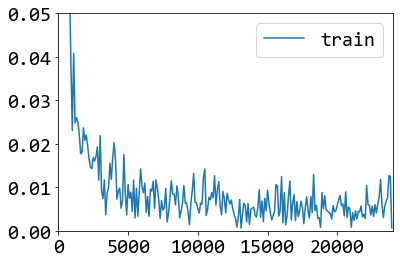

Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from output\silicon net_5x5 250x250 3x21x1840 4x5x5 0x3\model.ckpt-24000


Data Set: 100%|█████████████████████████████████████████████████████████████████| 60516/60516 [01:12<00:00, 832.78it/s]


In [27]:
gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.6, allow_growth = True)
with tf.Session(graph=graph, config=tf.ConfigProto(gpu_options=gpu_options)) as sess:
    ### Initialization
    sess.run(tf.local_variables_initializer())
    sess.run(tf.global_variables_initializer())

    ### We need to add this code because we use queue to read tfrecord files.
    coord   = tf.train.Coordinator()
    threads = tf.train.start_queue_runners(sess=sess, coord=coord)

    # ---------------------------------------------------------------- # 
    # --------------------------- Training --------------------------- # 
    # ---------------------------------------------------------------- # 
    
    ### Training
    if IS_TRAINING:
        ### Create model saver
        train_saver = tf.train.Saver()
        
        ### Progress
        mb = master_bar(range(ITERATION_STEP))
        ax = []
        ay = []
        
        ### Running
        for step in mb:
            ### Get data
            run_train_data = sess.run([train_data])
            train_data_n = run_train_data[0]['data_n']
            train_data_x = run_train_data[0]['data_x']
            train_data_y = run_train_data[0]['data_y']
            
            ### Train
            feed_dict = {is_training:True, batch_data_x:train_data_x, batch_data_y:train_data_y}
            run_train, run_loss = sess.run([train, loss], feed_dict=feed_dict)
            
            ### Print
            if step%100==0:
                ax.append(step)
                ay.append(run_loss)
                graphs   = [[ax, ay]]
                x_bounds = [0, ITERATION_STEP]
                y_bounds = [0, 0.05]
                mb.update_graph(graphs, x_bounds, y_bounds)

        ### Write model
        train_saver.save(sess, os.path.join(OUTPUT_URL, 'model.ckpt'), global_step=ITERATION_STEP)
      
    # ---------------------------------------------------------------- # 
    # ----------------------------- Test ----------------------------- # 
    # ---------------------------------------------------------------- # 
    
    ### Test
    if IS_TEST:
        ### Read model
        test_saver = tf.train.Saver()
        test_saver.restore(sess, os.path.join(OUTPUT_URL, 'model.ckpt-{0}'.format(ITERATION_STEP)))

        data_pixels = [[r, c] for r in range(NN_KERNEL_H//2, DATA_GT_H - NN_KERNEL_H//2) 
                              for c in range(NN_KERNEL_W//2, DATA_GT_W - NN_KERNEL_W//2)]
        
        nn_fitted_data = np.array(IMAGE_TEST_OUTPUT, dtype=np.float32)
        
        with tqdm(desc='Data Set', total=len(data_pixels)) as pbar:
            for data_pixel in data_pixels:
                ### Test data
                row = data_pixel[0]
                col = data_pixel[1]
                
                test_data_n = '{0}_{1}'.format(row, col)
                test_data_x = IMAGE_TEST_INPUT[:, 
                                               row-NN_KERNEL_H//2:row+NN_KERNEL_H//2+1, 
                                               col-NN_KERNEL_W//2:col+NN_KERNEL_W//2+1]
            
                test_data_x = np.divide(test_data_x.reshape((1, -1)), DATA_SCALE_IN)

                ### Test
                feed_dict = {is_training:False, batch_data_x:test_data_x}
                run_net_y = sess.run([net_y], feed_dict=feed_dict)

                ### Data processing
                nn_fitted_data[row, col] = np.multiply(run_net_y[0], DATA_SCALE_OUT)
                
                ### Update
                pbar.update(1)
                
            ### Data print and save
            np.save(NN_FITTED_DATA_NPY_URL, nn_fitted_data)
    
    ### Request stop the thread and wait it stop. 
    coord.request_stop()
    coord.join(threads)

## Analysis

### Calculate Data

In [28]:
# ---------------------------------------------------------------- # 
# ----------------------- Load Fitted Data ----------------------- # 
# ---------------------------------------------------------------- # 

IMAGE_TEST_OUTPUT = np.load(NN_FITTED_DATA_NPY_URL)

# ---------------------------------------------------------------- # 
# --------------------- Calculate Diff Data ---------------------- # 
# ---------------------------------------------------------------- # 

### Ground Truth
IMAGE_CMP_HEIGHT = IMAGE_CMP[INDEX_TRACE, :, :]

### GT VS Trace
IMAGE_TEST_DIFF_TRACE   = np.abs(np.subtract(IMAGE_CMP_HEIGHT, IMAGE_TEST_INPUT[INDEX_TRACE, :, :]))

### GT VS Trace
IMAGE_TEST_DIFF_RETRACE = np.abs(np.subtract(IMAGE_CMP_HEIGHT, IMAGE_TEST_INPUT[INDEX_RETRACE, :, :]))

### GT VS NN Output
IMAGE_TEST_DIFF_OUTPUT  = np.abs(np.subtract(IMAGE_CMP_HEIGHT, IMAGE_TEST_OUTPUT))

### Calculate the min and max
DIFF_MIN = np.min([IMAGE_TEST_DIFF_TRACE, IMAGE_TEST_DIFF_RETRACE, IMAGE_TEST_DIFF_OUTPUT])
DIFF_MAX = np.max([IMAGE_TEST_DIFF_TRACE, IMAGE_TEST_DIFF_RETRACE, IMAGE_TEST_DIFF_OUTPUT])

# ---------------------------------------------------------------- # 
# -------------------------- Crop Data --------------------------- # 
# ---------------------------------------------------------------- # 

CROP_R = range(NN_KERNEL_H//2, DATA_GT_H-NN_KERNEL_H//2)
CROP_C = range(NN_KERNEL_W//2, DATA_GT_W-NN_KERNEL_W//2)

### Image Comparison

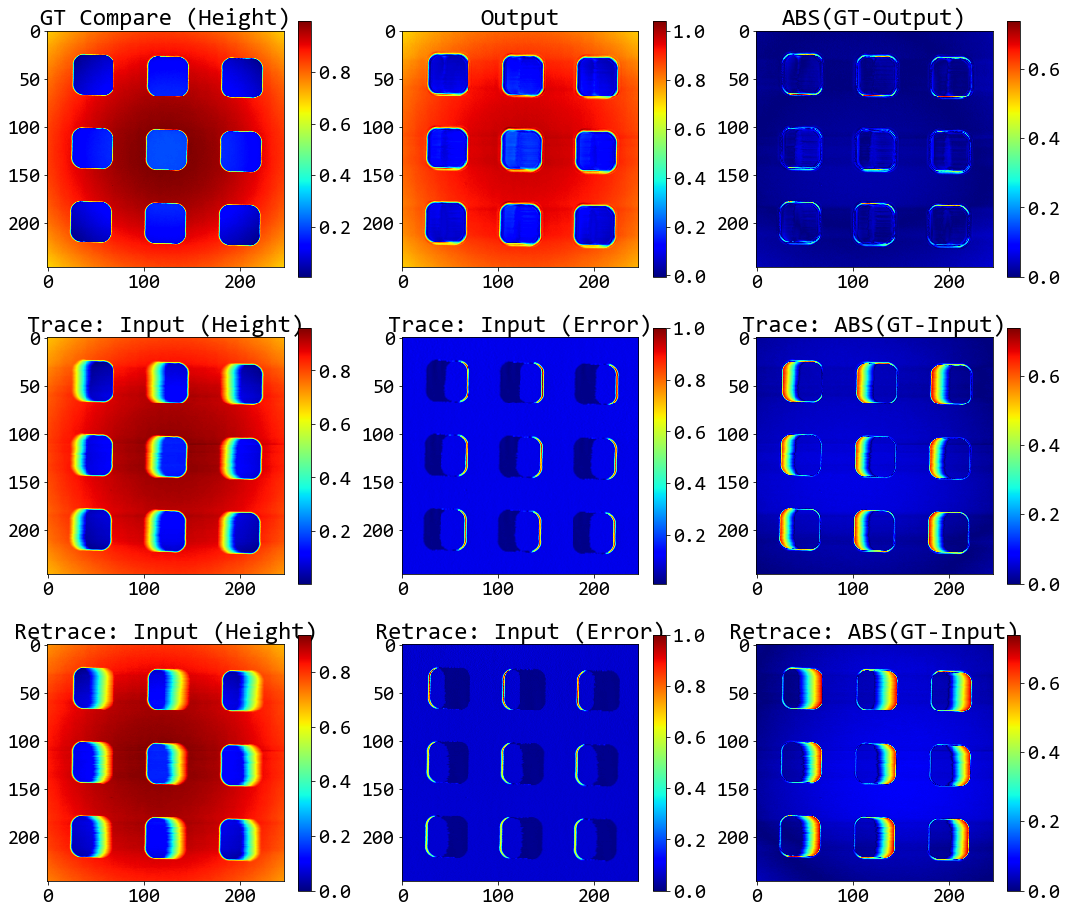

In [29]:
# Display
plt.figure(figsize=(18, 16))

# Ground Truth
plt.subplot(3, 3, 1)
plt.imshow(IMAGE_CMP_HEIGHT[CROP_R, :][:, CROP_C], cmap=CMAP)
plt.title('GT Compare (Height)')
plt.colorbar()

# NN Output
plt.subplot(3, 3, 2)
plt.imshow(IMAGE_TEST_OUTPUT[CROP_R, :][:, CROP_C], cmap=CMAP)
plt.title('Output')
plt.colorbar()

# Diff between GT and NN output
plt.subplot(3, 3, 3)
plt.imshow(IMAGE_TEST_DIFF_OUTPUT[CROP_R, :][:, CROP_C], cmap=CMAP, vmin=DIFF_MIN, vmax=DIFF_MAX)
plt.title('ABS(GT-Output)')
plt.colorbar()

### Trace
plt.subplot(3, 3, 4)
plt.imshow(IMAGE_TEST_INPUT[INDEX_TRACE, :, :][CROP_R, :][:, CROP_C], cmap=CMAP)
plt.title('Trace: Input (Height)')
plt.colorbar()

plt.subplot(3, 3, 5)
plt.imshow(IMAGE_TEST_INPUT[INDEX_TRACE+1, :, :][CROP_R, :][:, CROP_C], cmap=CMAP)
plt.title('Trace: Input (Error)')
plt.colorbar()

plt.subplot(3, 3, 6)
plt.imshow(IMAGE_TEST_DIFF_TRACE[CROP_R, :][:, CROP_C], cmap=CMAP, vmin=DIFF_MIN, vmax=DIFF_MAX)
plt.title('Trace: ABS(GT-Input)')
plt.colorbar()

### Retrace
plt.subplot(3, 3, 7)
plt.imshow(IMAGE_TEST_INPUT[INDEX_RETRACE, :, :][CROP_R, :][:, CROP_C], cmap=CMAP)
plt.title('Retrace: Input (Height)')
plt.colorbar()

plt.subplot(3, 3, 8)
plt.imshow(IMAGE_TEST_INPUT[INDEX_RETRACE+1, :, :][CROP_R, :][:, CROP_C], cmap=CMAP)
plt.title('Retrace: Input (Error)')
plt.colorbar()

plt.subplot(3, 3, 9)
plt.imshow(IMAGE_TEST_DIFF_RETRACE[CROP_R, :][:, CROP_C], cmap=CMAP, vmin=DIFF_MIN, vmax=DIFF_MAX)
plt.title('Retrace: ABS(GT-Input)')
plt.colorbar()

plt.show()

### RMSE & SSIM & PSNR Comparison

In [30]:
# ---------------------------------------------------------------- # 
# ----------------------------- MAE ------------------------------ # 
# ---------------------------------------------------------------- # 

MAE_NN = MAE(IMAGE_CMP_HEIGHT[CROP_R, :][:, CROP_C], IMAGE_TEST_OUTPUT[CROP_R, :][:, CROP_C], L=256)
MAE_S1 = MAE(IMAGE_CMP_HEIGHT[CROP_R, :][:, CROP_C], IMAGE_TEST_INPUT[INDEX_TRACE, :, :][CROP_R, :][:, CROP_C], L=256)
MAE_S2 = MAE(IMAGE_CMP_HEIGHT[CROP_R, :][:, CROP_C], IMAGE_TEST_INPUT[INDEX_RETRACE, :, :][CROP_R, :][:, CROP_C], L=256)

print('MAE of 慢扫图 VS 修正图           = {0}'.format(np.round(MAE_NN, 4)))
print('MAE of 慢扫图 VS 快扫图 (Trace)   = {0}'.format(np.round(MAE_S1, 4)))
print('MAE of 慢扫图 VS 快扫图 (Retrace) = {0}'.format(np.round(MAE_S2, 4)))
print()

# ---------------------------------------------------------------- # 
# ----------------------------- RMSE ----------------------------- # 
# ---------------------------------------------------------------- # 

RMSE_NN = RMSE(IMAGE_CMP_HEIGHT[CROP_R, :][:, CROP_C], IMAGE_TEST_OUTPUT[CROP_R, :][:, CROP_C], L=256)
RMSE_S1 = RMSE(IMAGE_CMP_HEIGHT[CROP_R, :][:, CROP_C], IMAGE_TEST_INPUT[INDEX_TRACE, :, :][CROP_R, :][:, CROP_C], L=256)
RMSE_S2 = RMSE(IMAGE_CMP_HEIGHT[CROP_R, :][:, CROP_C], IMAGE_TEST_INPUT[INDEX_RETRACE, :, :][CROP_R, :][:, CROP_C], L=256)

print('RMSE of 慢扫图 VS 修正图           = {0}'.format(np.round(RMSE_NN, 4)))
print('RMSE of 慢扫图 VS 快扫图 (Trace)   = {0}'.format(np.round(RMSE_S1, 4)))
print('RMSE of 慢扫图 VS 快扫图 (Retrace) = {0}'.format(np.round(RMSE_S2, 4)))
print()

# ---------------------------------------------------------------- # 
# ----------------------------- SSIM ----------------------------- # 
# ---------------------------------------------------------------- # 

SSIM_NN = SSIM(IMAGE_CMP_HEIGHT[CROP_R, :][:, CROP_C], IMAGE_TEST_OUTPUT[CROP_R, :][:, CROP_C])
SSIM_S1 = SSIM(IMAGE_CMP_HEIGHT[CROP_R, :][:, CROP_C], IMAGE_TEST_INPUT[INDEX_TRACE, :, :][CROP_R, :][:, CROP_C])
SSIM_S2 = SSIM(IMAGE_CMP_HEIGHT[CROP_R, :][:, CROP_C], IMAGE_TEST_INPUT[INDEX_RETRACE, :, :][CROP_R, :][:, CROP_C])

print('SSIM of 慢扫图 VS 修正图           = {0}'.format(np.round(SSIM_NN, 4)))
print('SSIM of 慢扫图 VS 快扫图 (Trace)   = {0}'.format(np.round(SSIM_S1, 4)))
print('SSIM of 慢扫图 VS 快扫图 (Retrace) = {0}'.format(np.round(SSIM_S2, 4)))
print()

# ---------------------------------------------------------------- # 
# ----------------------------- PSNR ----------------------------- # 
# ---------------------------------------------------------------- # 

PSNR_NN = PSNR(IMAGE_CMP_HEIGHT[CROP_R, :][:, CROP_C], IMAGE_TEST_OUTPUT[CROP_R, :][:, CROP_C])
PSNR_S1 = PSNR(IMAGE_CMP_HEIGHT[CROP_R, :][:, CROP_C], IMAGE_TEST_INPUT[INDEX_TRACE, :, :][CROP_R, :][:, CROP_C])
PSNR_S2 = PSNR(IMAGE_CMP_HEIGHT[CROP_R, :][:, CROP_C], IMAGE_TEST_INPUT[INDEX_RETRACE, :, :][CROP_R, :][:, CROP_C])

print('PSNR of 慢扫图 VS 修正图           = {0}'.format(np.round(PSNR_NN, 4)))
print('PSNR of 慢扫图 VS 快扫图 (Trace)   = {0}'.format(np.round(PSNR_S1, 4)))
print('PSNR of 慢扫图 VS 快扫图 (Retrace) = {0}'.format(np.round(PSNR_S2, 4)))
print()

MAE of 慢扫图 VS 修正图           = 5.8909
MAE of 慢扫图 VS 快扫图 (Trace)   = 17.534
MAE of 慢扫图 VS 快扫图 (Retrace) = 21.2214

RMSE of 慢扫图 VS 修正图           = 12.7318
RMSE of 慢扫图 VS 快扫图 (Trace)   = 33.165
RMSE of 慢扫图 VS 快扫图 (Retrace) = 38.1815

SSIM of 慢扫图 VS 修正图           = 0.9597
SSIM of 慢扫图 VS 快扫图 (Trace)   = 0.8771
SSIM of 慢扫图 VS 快扫图 (Retrace) = 0.8595

PSNR of 慢扫图 VS 修正图           = 26.067
PSNR of 慢扫图 VS 快扫图 (Trace)   = 17.7512
PSNR of 慢扫图 VS 快扫图 (Retrace) = 16.5277

